In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import string
import itertools
from tqdm import tqdm
from scipy import stats
from geolite2 import geolite2  # pip install maxminddb-geolite2

In [8]:
geo = geolite2.reader()

def extract_country(x):
    out = np.nan
    try:
        # out = geo.get(x)['country']['names']['en']
        out = geo.get(x)['country']['iso_code']
    except:
        pass
    return out


### Procedure

1. Load all historical data.
2. Create the network
    * Connect all miners to all workers/owners seen
    * Connect all miners to all control addresses
3. Split the disconnected network into connected subgraphs
4. Find all subgraphs with at least one geolocated miner.
5. With subgraphs selected from (4), construct an output dataframe of locations

In [159]:
# 1a. Load worker relationship data
data = pd.read_csv('../data/worker_relationship_jun_19.csv', index_col=[0])
dsplt = data['multi_addresses'].str.split('/', expand=True)
dsplt = dsplt[dsplt.columns[2]]
data['ip'] = dsplt
del dsplt

# 1b. Load Dylan's list of active miners
df_active_miners = pd.read_csv('../data/dylan_map.csv', index_col=[0])
active_miners = df_active_miners.miner_id.unique()
data['is_active_miner'] = data.miner_id.isin(active_miners)

# 1c. Extract country
data['country'] = data['ip'].apply(extract_country)

# 2. Create network
# 2a. Connect all miners to workers/owners seen
G = nx.Graph()
for m,c in zip(data.miner_id, data.country):
    G.add_node(m, country=c)
G.add_edges_from([mi, wi] for mi, wi in data[['miner_id', 'worker_id']].drop_duplicates().values)
G.add_edges_from([mi, oi] for mi, oi in data[['miner_id', 'owner_id']].drop_duplicates().values)

# 2b. Connect all miners to their control addresses
for mi, ca in zip(data.miner_id, data.control_addresses):
    ca_string = str(ca)
    if ca_string[0] == '[':
        
        # Only one control address
        if ',' not in ca_string:
            ca_out = ca_string.translate(str.maketrans('', '', string.punctuation))
            G.add_edge(mi, ca_out)

        # Multiple control addresses 
        else:
            ca_list = ca_string.translate(str.maketrans('', '', string.punctuation)).split(" ")
            for ca in ca_list:
                G.add_edge(mi,ca)            

# 3. Split the network into connected subgraphs
all_components = sorted(nx.connected_components(G), key=len)[::-1]

In [177]:
# 4. Find all subgraphs with more than one geolocated country
selected_subgraph_idx = []
countries_seen_in_subgraph = {}
t = tqdm(range(len(all_components)))
for i in t:
    t.set_description('Subgraph %i' % i)
    miners_in_each_subnetwork = list(all_components[i])
    miner_count_of_countries = data[data.miner_id.isin(miners_in_each_subnetwork)].\
                                                                           groupby('country').sum().\
                                                                           sort_values(by='is_active_miner', ascending=False).\
                                                                           is_active_miner
    if miner_count_of_countries.sum() > 0:
        selected_subgraph_idx.append(i)
        countries_seen_in_subgraph[i] = miner_count_of_countries

Subgraph 8858: 100%|████████████████████████| 8859/8859 [02:33<00:00, 57.60it/s]


In [285]:
df_out = pd.DataFrame(columns=['node', 'original_geolocated', 'country'])
for subgraph_idx in tqdm(selected_subgraph_idx):
    nodes_in_subgraph = list(all_components[subgraph_idx])
    reference_df = data[data.miner_id.isin(nodes_in_subgraph)]
    geolocated_miners = data[data.miner_id.isin(nodes_in_subgraph) & ~data.country.isnull()].miner_id.unique()
    confidences = reference_df.country.value_counts() /reference_df.country.value_counts().sum() 
    
    for node in nodes_in_subgraph:
        
        # If original node is geolocated, set its location 
        if node in geolocated_miners:
            dict_to_append = {
                'node': node,
                'original_geolocated': True,
                'country': reference_df[reference_df.miner_id==node].country.dropna().unique()[0],
                'confidence': 1
            }
            df_out = pd.concat([df_out, pd.DataFrame(dict_to_append, index=[0])])
            
        else:
            # If the node wasn't originally geolocated, note the modal location and confidence
            inferred_country = reference_df.country.value_counts().index[0]
            dict_to_append = {
                'node': node,
                'original_geolocated': False,
                'country': inferred_country,
                'confidence': confidences[inferred_country]
            }
            df_out = pd.concat([df_out, pd.DataFrame(dict_to_append, index=[0])])
            

100%|█████████████████████████████████████████| 387/387 [00:45<00:00,  8.42it/s]


In [299]:
df_final = pd.DataFrame(df_active_miners.miner_id.unique(), columns=['miner_id'])\
             .merge(df_out, left_on='miner_id', right_on='node')

In [337]:
df_final

,miner_id,node,original_geolocated,country,confidence
0,f0109070,f0109070,False,SG,0.304348
1,f01753718,f01753718,False,US,1.000000
2,f045779,f045779,False,CN,0.347826
3,f087081,f087081,False,US,0.750000
4,f01236251,f01236251,False,CN,1.000000
...,...,...,...,...,...
2979,f0133509,f0133509,True,HK,1.000000
2980,f01794610,f01794610,True,US,1.000000
2981,f01936456,f01936456,True,VN,1.000000
2982,f024016,f024016,True,US,1.000000


Text(0.5, 1.0, 'Distribution of miners by country')

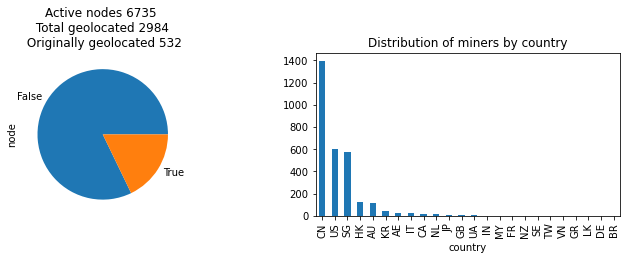

In [336]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,3))
df_final.groupby('original_geolocated').count().node.plot(kind='pie', ax=ax1)
df_final.groupby('country').count().node.sort_values(ascending=False).plot(kind='bar', ax=ax2)
ax1.set_title('Active nodes %i \n Total geolocated %i \n Originally geolocated %i' % (len(df_active_miners.miner_id.unique()) , len(df_final), len(df_final[df_final.original_geolocated==True])))
ax2.set_title('Distribution of miners by country')